In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
%matplotlib inline
from statsmodels.formula.api import ols
import numpy as np
import src
import random
import scipy.stats as stats



# Methodology

My approach to this model was to do some eda to find strongly correlated variables, then work from the ground up to add features one at a time and see their effect. As such this notebook can dawdle somewhat, but I did not want to deviate its structure too much from my though process. 

In [99]:
df = pd.read_csv("kc_house_data_train.csv")
fedfunds = pd.read_csv("fedfunds")
fedfunds['year_month'] = fedfunds['year_month'].astype(str)
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


[(0, 2985984)]

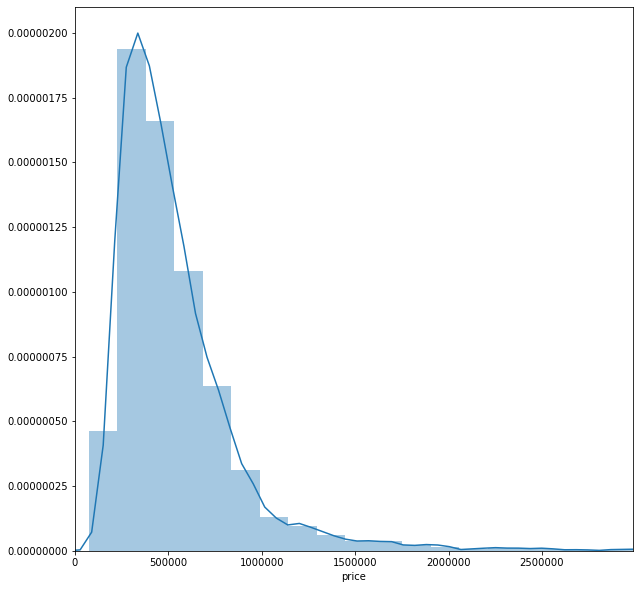

In [100]:
fig2, axes = plt.subplots( figsize = (10,10))
ax = sns.distplot(df.price)
ax.set(xlim = (0,12**6))


There are alot of outlier prices, super expensive mansions or whatever, Cant do too much as its the target variable, but it will defintely negatively effect the model. 

In [101]:
df.corr()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
Unnamed: 0,1.000000e+00,-0.006139,-0.012306,-0.010271,-0.004940,-0.008900,-0.003500,0.010599,-0.008845,-6.278161e-07,...,-0.005015,-0.003406,-0.012104,0.007496,-0.003423,0.006218,0.002470,-0.006992,-0.008961,0.000463
id,-6.138777e-03,1.000000,-0.015644,-0.001529,0.003833,-0.014251,-0.129837,0.017126,0.000101,1.259374e-02,...,0.003163,-0.013932,-0.003516,0.013697,-0.019560,-0.008166,-0.001865,0.017388,-0.007494,-0.139605
price,-1.230630e-02,-0.015644,1.000000,0.305106,0.524335,0.703540,0.086803,0.256985,0.275779,3.954851e-01,...,0.666215,0.607760,0.323312,0.056450,0.117770,-0.048958,0.302394,0.019327,0.585567,0.081423
bedrooms,-1.027127e-02,-0.001529,0.305106,1.000000,0.507867,0.570428,0.029375,0.172975,-0.008581,7.974076e-02,...,0.354679,0.472492,0.300085,0.153769,0.013679,-0.147515,-0.002170,0.124279,0.387589,0.026665
bathrooms,-4.939574e-03,0.003833,0.524335,0.507867,1.000000,0.755270,0.085470,0.497967,0.065848,1.888170e-01,...,0.664191,0.686853,0.282700,0.507761,0.048140,-0.201527,0.023074,0.221308,0.568080,0.086499
sqft_living,-8.900440e-03,-0.014251,0.703540,0.570428,0.755270,1.000000,0.166810,0.357169,0.109738,2.833358e-01,...,0.762929,0.876696,0.435529,0.319397,0.051448,-0.195893,0.052646,0.234453,0.755066,0.179570
sqft_lot,-3.500101e-03,-0.129837,0.086803,0.029375,0.085470,0.166810,1.000000,-0.002205,0.015356,7.305841e-02,...,0.110320,0.180755,0.008065,0.054228,0.004520,-0.126590,-0.082029,0.226190,0.136959,0.701875
floors,1.059874e-02,0.017126,0.256985,0.172975,0.497967,0.357169,-0.002205,1.000000,0.025132,2.588299e-02,...,0.458984,0.528509,-0.247481,0.483657,0.005985,-0.060560,0.048227,0.128795,0.283933,-0.008170
waterfront,-8.844970e-03,0.000101,0.275779,-0.008581,0.065848,0.109738,0.015356,0.025132,1.000000,4.075653e-01,...,0.092234,0.077162,0.083433,-0.021981,0.094268,0.034282,-0.013331,-0.042728,0.091090,0.026895
view,-6.278161e-07,0.012594,0.395485,0.079741,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000e+00,...,0.249554,0.164747,0.279939,-0.049593,0.091291,0.089475,0.003820,-0.077572,0.279999,0.073185


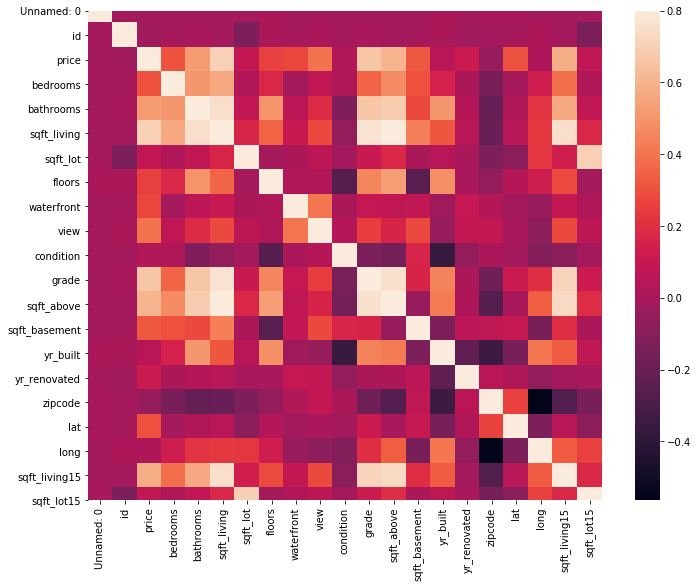

In [102]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

an initial exploration of the correlation table, trying to pick out features which are crucial and ones that can be reomved, sqft seems like the best bet, view and water front dont correlate as much as I would have thought. It looks the separate sqft variables can just be combined into one sqft variable since they are correlated. One of the biggest colinearity issues might be grade and sqft, ideally they would tell us different things about the home but it looks like they have fairly high correlation.

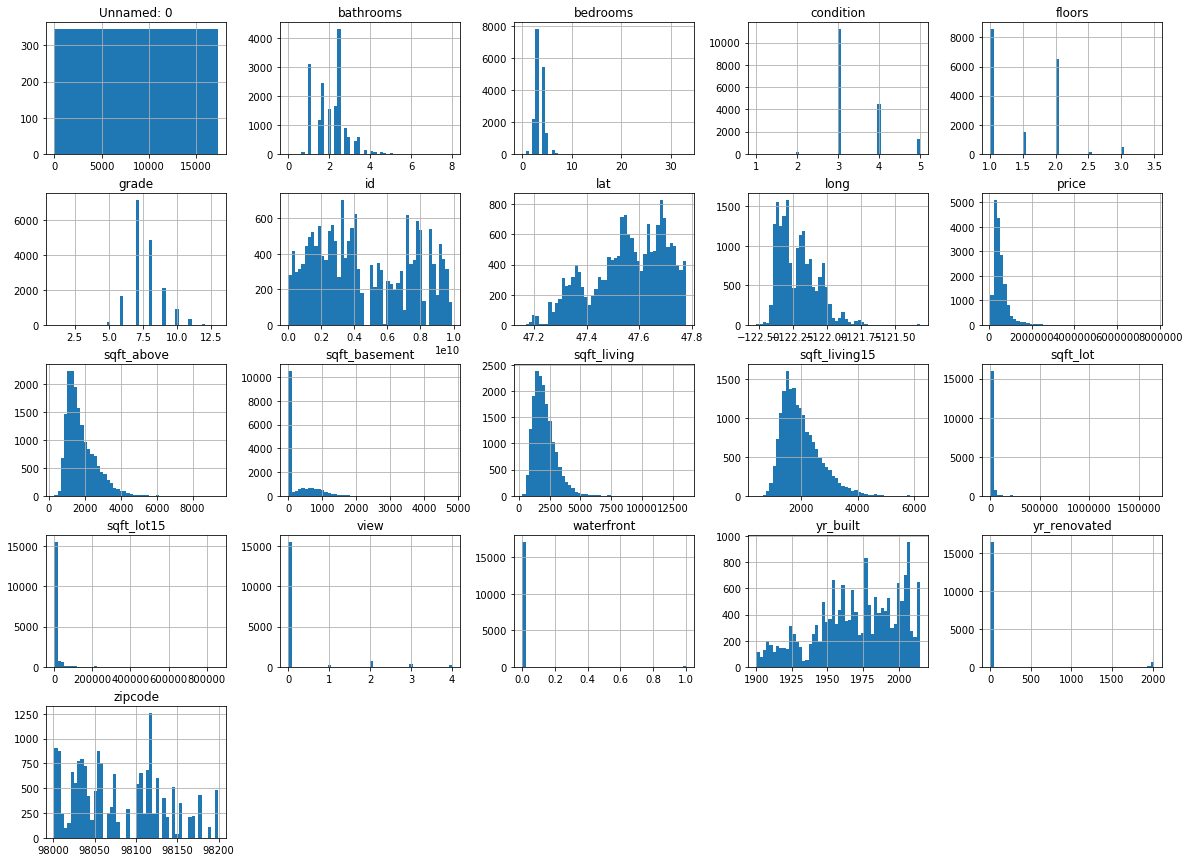

In [103]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Show us some more outliers. I found the yr built graph fascinating since it shows how much building has dropped since the spike in 2000. Year renovated is 0 for almost every datapoints which I think means the house has never been renovated, not that it was renovated 2000 years ago by Jesus himself. All the sqft measures, bedrooms and are skewed to the right, I think lowering some of these outliers will help the model but ill experiment both ways. 

In [104]:
def remove_outliers(x):
    std = x.std()
    two_std = x.mean() + 3*std
    return np.where(x < two_std, x, two_std)

In [105]:
df['sqft_living_n'] = remove_outliers(df.sqft_living)
df['bedrooms_n'] = remove_outliers(df.bedrooms)
df['sqft_above_n'] = remove_outliers(df.sqft_above)

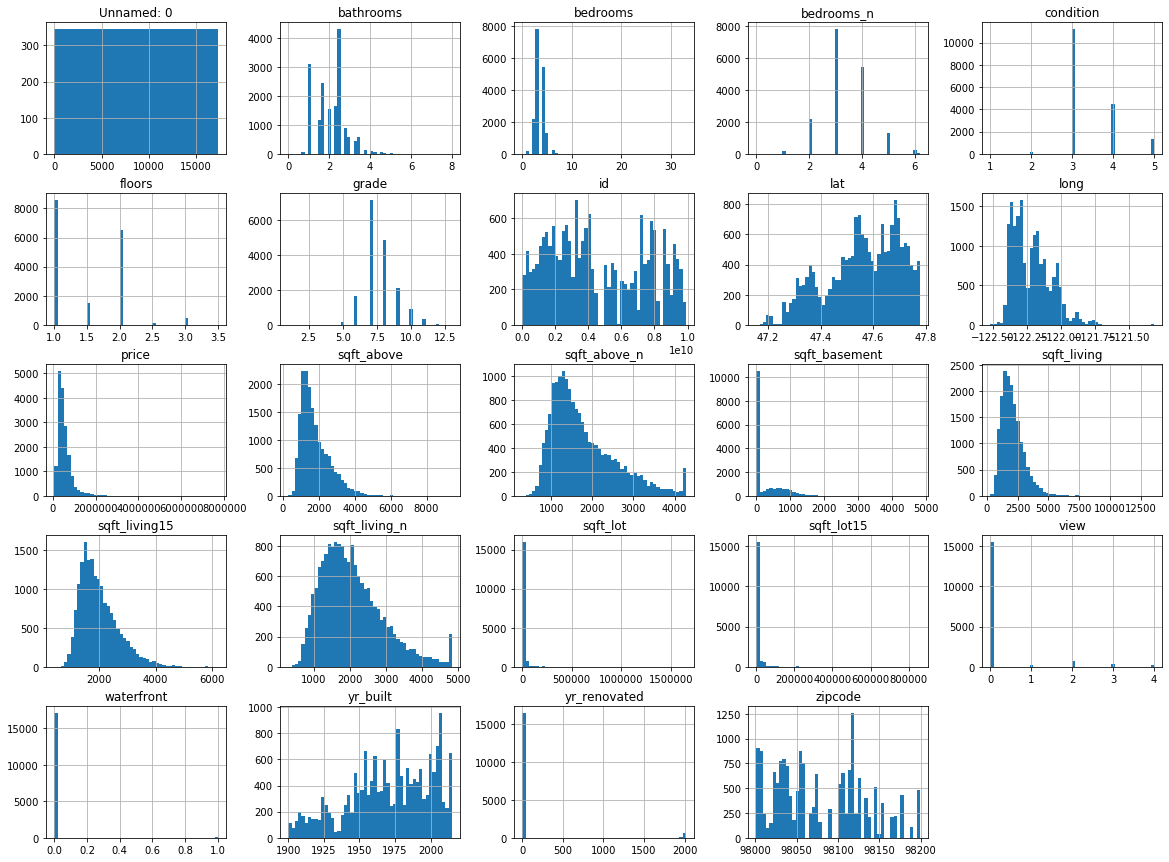

In [106]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [107]:
df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

Already seems to be a dummy variable, where 1 is yes and 0 is no. Lets run a t-test at a signifigance level of .05 to make sure this is a significant variable.

In [108]:
from scipy.stats import ttest_ind

waterfront = df[df['waterfront'] == 1]['price']
no_waterfront = df[df['waterfront'] == 0]['price']

ttest_ind(waterfront, no_waterfront)


Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

Null Hypothesis: There is no difference between the average price of waterfront properties and non waterfront properties. 

Alternative Hypothesis: There is a significant difference in average price of waterfron properties and non waterfront properties. 

At a signifigance level of .05 we reject the null hypothesis. Waterfront properties will be a significant predictor of price.

In [109]:
df.view.value_counts()

0    15571
2      775
3      410
4      270
1      264
Name: view, dtype: int64

Ranks the view from 0-4, I think this can be implemented as is, higher view = higher price? But I will also try making dummy variables just to see later on. I wonder if squaring the 4 value could help with extremely expensive houses. I will run an anova test to confirm that there is a significant difference in average price based on the view grade of the house. 
Signifigance level: 0.05
Null hypothesis: There is no difference between the average price of a house which is graded with a different view.
Alternative hypothesis: There is a difference between the average price of a house at different view grades.

In [110]:

stats.f_oneway(df['price'][df['view'] == 0],
               df['price'][df['view'] == 1],
               df['price'][df['view'] == 2],
               df['price'][df['view'] == 3],
               df['price'][df['view'] == 4])

F_onewayResult(statistic=876.7689357683041, pvalue=0.0)

Tons of the houses just don't have basements, lets create a variable for houses with basements and see if there is asignificant difference between those houses with basements and those without.

Null Hypothesis: A home having a basement leads to no difference in average price.
Alternative: A home having a basement does lead to a difference in price.

In [111]:
df['has_basement'] = df['sqft_basement'].apply(lambda x: x > 0).astype(int)

basement = df[df['has_basement'] == 1]['price']
no_base = df[df['has_basement'] < 1]['price'] 

ttest_ind(basement, no_base)



Ttest_indResult(statistic=23.64189256331611, pvalue=1.2107663322174255e-121)

The p value is lower than our signifigance level so we can reject the null hypothesis. A home having a basement does a have a significant effect on price. I will make sure to incorporate this variable in my regression. 

# Regression Modeling Proccess

Throughout this process I used a wrapper method to build my model. I chose this process becuase I predicted location and square footage would account for the majority of variance in price, so I first implemented those two features then moved onto finetuning. My process relied on p values from the ols linear regression model. At first I used a signifigance level of 0.05 but later went for .5 as the goal of this model is accuracy and not interpretability. Scatter plot were used to see the relationship between different variables and price. 

# Location Location Location 

Lets start engineering some features. I think location was the first thing that jumped into my mind when I though of housing prices. I'll start with zipcode, but there might be better metrics I can use later. 

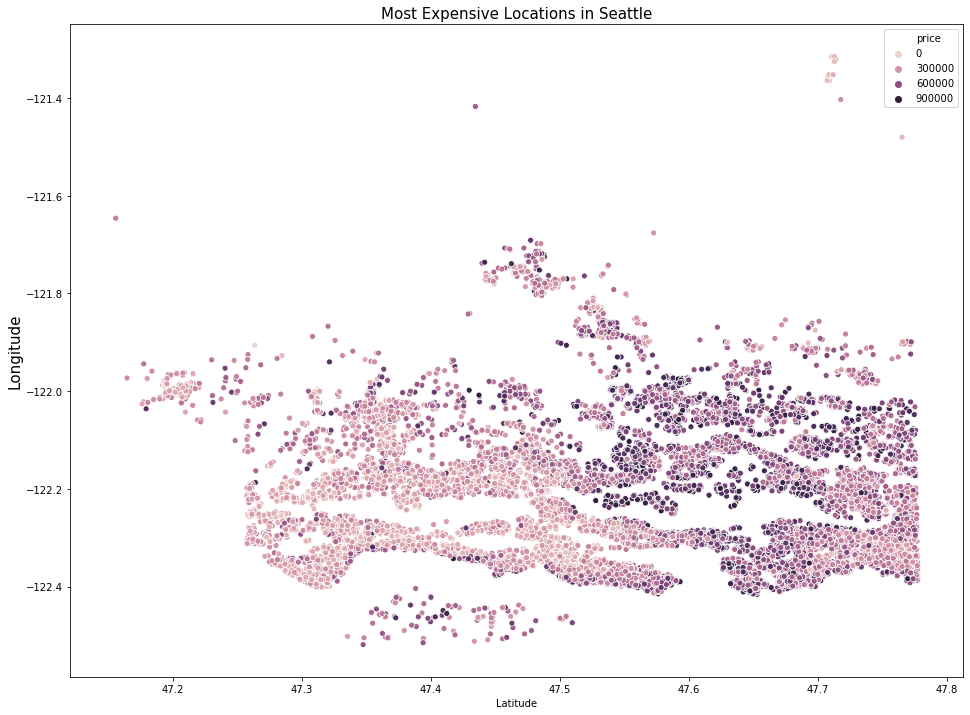

In [288]:
fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.scatterplot(x ='lat', y = 'long', hue = 'price', data = df[df.price< 900000])
ax.set_title('Most Expensive Locations in Seattle', size = 15)
ax.set_ylabel('Longitude', size = 15)
ax.set_xlabel('Latitude')
plt.savefig('lat_long_data_viz.png')

Text(0.5, 0, 'Best View Locations in Seattle')

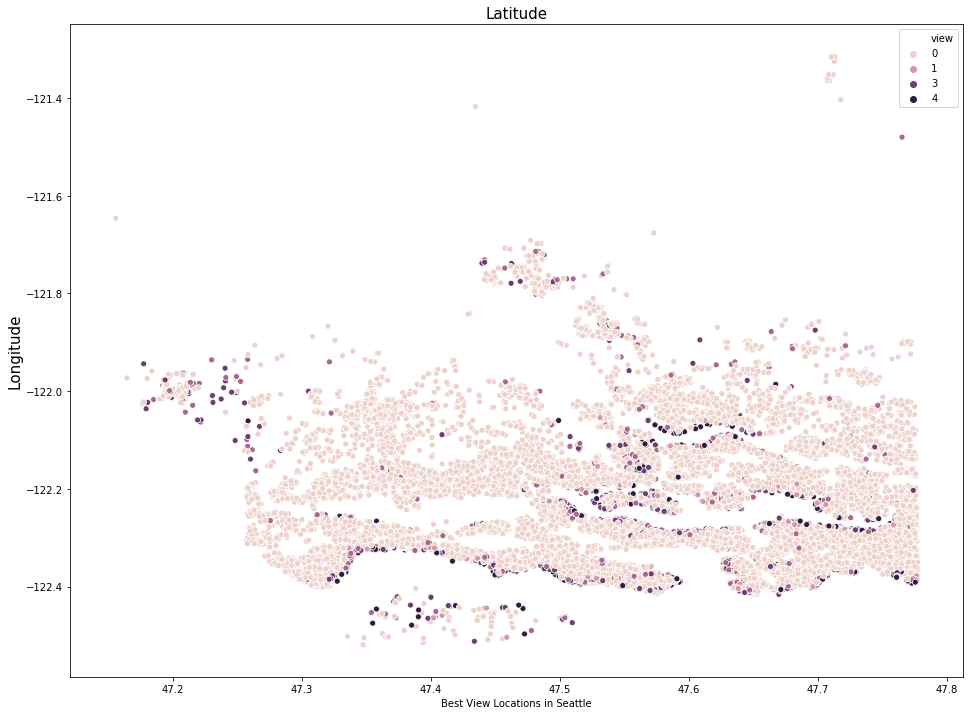

In [113]:
fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.scatterplot(x ='lat', y = 'long', hue = 'view', data = df)
ax.set_title('Latitude', size = 15)
ax.set_ylabel('Longitude', size = 15)
ax.set_xlabel('Best View Locations in Seattle')

These latitude- longitude scatter plots serve as visualization for expensive areas. Expensive areas do not seem to correlate directly with view, which makes sense as view is a much smaller selection of areas. In the one that has price as hue I limited it to below 900,000 so it would scale better for the variety of neighborhoods. This scale will not be part of my model however. 

Text(0.5, 0, 'Average Price of Houses Sold')

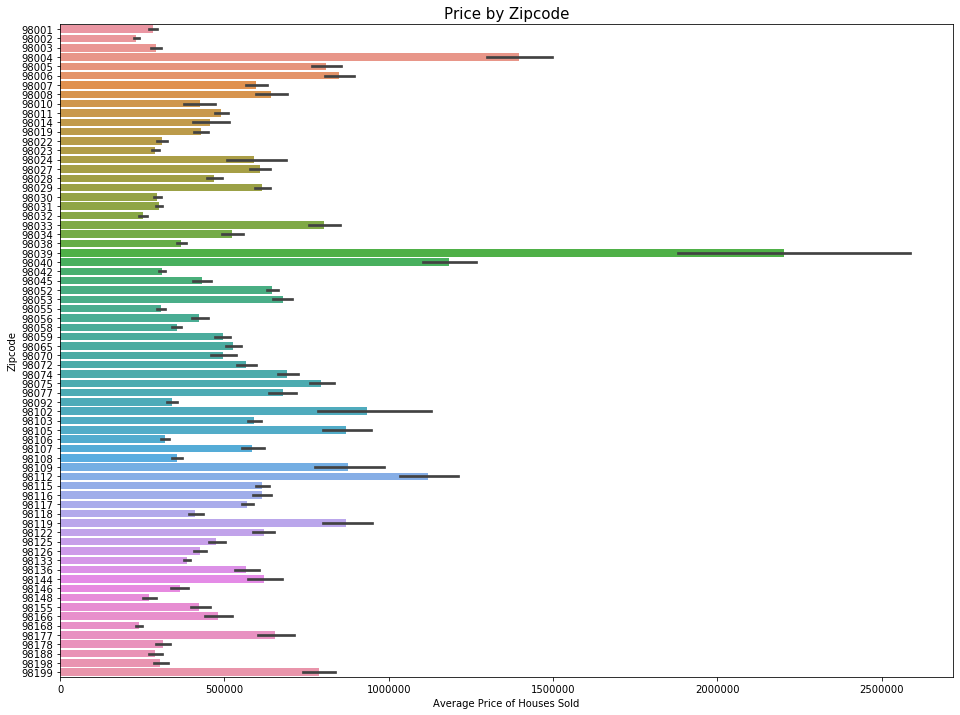

In [114]:

fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.barplot(df.price, df.zipcode, orient = 'h')
ax.set_title('Price by Zipcode', size = 15)
ax.set_ylabel('Zipcode', size = 10)
ax.set_xlabel('Average Price of Houses Sold')

In [276]:
lat_long = df.groupby(['lat', 'long'])['price'].mean().sort_values(ascending = False)[0:10].index

for x in range(0,len(lat_long)):
    df['ll'+str(x)] = ((df.lat - lat_long[x][0])**2 + (df.long - lat_long[x][1])**2) 
df.head()

,Unnamed: 0,id,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,ll1,ll0,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9
0,0,2591820310,20141006T000000,365000.0,4,2070,8893,2.0,0,4,...,0.047309,0.062402,0.042833,0.041179,0.037367,0.017754,0.058997,0.016275,0.110334,0.036373
1,7,7010701383,20141017T000000,680000.0,3,1800,4400,1.0,0,5,...,0.033222,0.006235,0.025200,0.027530,0.032323,0.043966,0.034507,0.045184,0.021448,0.032858
2,17,2386000070,20141029T000000,795127.0,4,4360,91158,1.0,0,3,...,0.052545,0.114344,0.065111,0.061623,0.055501,0.056508,0.052438,0.057481,0.099015,0.055117
3,18,1138000450,20141016T000000,355000.0,4,1440,7215,1.5,0,3,...,0.004011,0.019293,0.007640,0.007564,0.008182,0.022564,0.001341,0.024434,0.005920,0.008605
4,23,9324800450,20141009T000000,560000.0,3,2790,6900,1.0,0,3,...,0.012332,0.011834,0.012769,0.013820,0.016636,0.034882,0.009076,0.036990,0.000336,0.017305


This visualization is a deeper dive on location where the average prices of each zip houses sold in each zipcode. Price seems to vary drastically by zipcode. This is expected since zipcode is our proxy for urbanization, school districts etc... 98038 has the highest zipcode, 98002 seems to be the lowest. It will be interesting to see which zipcodes are significant in our model.

In [115]:
dummies = pd.get_dummies(df.zipcode)
data = pd.concat([df.price, dummies], axis = 1)

In [116]:
corr_mat = data.corr().sort_values('price', ascending = False)[0:10]['price']

In [117]:
corr_mat

price    1.000000
98004    0.270366
98039    0.219701
98040    0.199329
98112    0.174365
98006    0.124801
98033    0.101606
98075    0.087974
98105    0.087568
98119    0.082551
Name: price, dtype: float64

This Matrix shows the zipcodes which have the biggest positive correlation to price, surprisingly, different from the bar graph 98004 has a bigger correlation than 98039. 

In [118]:
corr_mat = data.corr().sort_values('price')[0:10]['price']

In [119]:
corr_mat

98023   -0.104858
98042   -0.098235
98168   -0.090086
98001   -0.089569
98002   -0.079096
98003   -0.076717
98038   -0.075885
98058   -0.075343
98106   -0.074458
98031   -0.072183
Name: price, dtype: float64

And the worst 

Now we will implement the dummy zipcode variables into our dataframe and make our first linear regression model!

In [120]:
df = pd.get_dummies(df, columns = ['zipcode'], drop_first = True)
zipcodes = []
for x in df.columns:
    if 'zipcode' in x:
        zipcodes.append(x)

In [121]:
zipcode_str = ' '.join(map(str, zipcodes))
zipcode_str

'zipcode_98002 zipcode_98003 zipcode_98004 zipcode_98005 zipcode_98006 zipcode_98007 zipcode_98008 zipcode_98010 zipcode_98011 zipcode_98014 zipcode_98019 zipcode_98022 zipcode_98023 zipcode_98024 zipcode_98027 zipcode_98028 zipcode_98029 zipcode_98030 zipcode_98031 zipcode_98032 zipcode_98033 zipcode_98034 zipcode_98038 zipcode_98039 zipcode_98040 zipcode_98042 zipcode_98045 zipcode_98052 zipcode_98053 zipcode_98055 zipcode_98056 zipcode_98058 zipcode_98059 zipcode_98065 zipcode_98070 zipcode_98072 zipcode_98074 zipcode_98075 zipcode_98077 zipcode_98092 zipcode_98102 zipcode_98103 zipcode_98105 zipcode_98106 zipcode_98107 zipcode_98108 zipcode_98109 zipcode_98112 zipcode_98115 zipcode_98116 zipcode_98117 zipcode_98118 zipcode_98119 zipcode_98122 zipcode_98125 zipcode_98126 zipcode_98133 zipcode_98136 zipcode_98144 zipcode_98146 zipcode_98148 zipcode_98155 zipcode_98166 zipcode_98168 zipcode_98177 zipcode_98178 zipcode_98188 zipcode_98198 zipcode_98199'

In [122]:
from statsmodels.formula.api import ols

slr_model = ols(formula= """price~zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022 
                            +zipcode_98023+zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032 
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166+zipcode_98168 
                            +zipcode_98177+zipcode_98178+zipcode_98188+zipcode_98198+zipcode_98199""", data=df).fit()
slr_model.summary()

# zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005 
# +zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
# +zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022 
# +zipcode_98023 zipcode_98024+zipcode_98027+zipcode_98028 
# +zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032 
# +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
# +zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052 
# +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
# +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
# +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
# +zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106 
# +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
# +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
# +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
# +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
# +zipcode_98148+zipcode_98155+zipcode_98166+zipcode_98168 
# +zipcode_98177+zipcode_98178+zipcode_98188+zipcode_98198+zipcode_98199

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     167.4
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:32:27   Log-Likelihood:            -2.4193e+05
No. Observations:               17290   AIC:                         4.840e+05
Df Residuals:                   17220   BIC:                         4.845e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       2.82e+05   1.72e+04     16.421      0.000    2.48e+05    3.16e+05
zipcode_98002 -4.971e+04   2.88e+04     -1.727      0.084   -1.06e+05    6701.740
zipcode_98003  8763.9215   2.59e+04      0.339      0.735   -4.19e+04    5.95e+04
zipcode_98004  1.115e+06   2.55e+04     43.787      0.000    1.06e+06    1.16e+06
zipcode_98005  5.268e+05   2.99e+04     17.629      0.000    4.68e+05    5.85e+05
zipcode_98006  5.675e+05   2.26e+04     25.068      0.000    5.23e+05    6.12e+05
zipcode_98007  3.156e+05   3.13e+04     10.073      0.000    2.54e+05    3.77e+05
zipcode_98008  3.588e+05   2.58e+04     13.907      0.000    3.08e+05    4.09e+05
zipcode_98010  1.429e+05   3.78e+04      3.783      0.000    6.88e+04    2.17e+05
zipcode_98011  2.086e+05   2.84e+04      7.337      0.000    1.53e+05    2.64e+05
zipcode_98014  1.742e+05   3.35e+04      5.196      0.000    1.08e+05     2.4e+05
zipcode_98019  1.464e+05   2.95e+04      4.957      0.000    8.85e+04    2.04e+05
zipcode_98022  2.677e+04   2.72e+04      0.985      0.324   -2.65e+04       8e+04
zipcode_98023  7573.8820   2.23e+04      0.339      0.735   -3.62e+04    5.14e+04
zipcode_98024   3.09e+05   3.98e+04      7.765      0.000    2.31e+05    3.87e+05
zipcode_98027  3.253e+05   2.34e+04     13.907      0.000    2.79e+05    3.71e+05
zipcode_98028  1.864e+05    2.6e+04      7.163      0.000    1.35e+05    2.37e+05
zipcode_98029  3.337e+05   2.51e+04     13.295      0.000    2.84e+05    3.83e+05
zipcode_98030   1.44e+04   2.67e+04      0.540      0.589   -3.79e+04    6.67e+04
zipcode_98031   1.86e+04   2.62e+04      0.711      0.477   -3.27e+04    6.99e+04
zipcode_98032  -3.04e+04   3.33e+04     -0.913      0.361   -9.56e+04    3.48e+04
zipcode_98033  5.207e+05    2.3e+04     22.601      0.000    4.76e+05    5.66e+05
zipcode_98034  2.419e+05   2.21e+04     10.955      0.000    1.99e+05    2.85e+05
zipcode_98038  8.642e+04   2.19e+04      3.949      0.000    4.35e+04    1.29e+05
zipcode_98039  1.921e+06   4.78e+04     40.147      0.000    1.83e+06    2.01e+06
zipcode_98040   9.01e+05   2.57e+04     35.055      0.000    8.51e+05    9.51e+05
zipcode_98042  2.717e+04   2.22e+04      1.224      0.221   -1.63e+04    7.07e+04
zipcode_98045  1.493e+05   2.78e+04      5.378      0.000    9.49e+04    2.04e+05
zipcode_98052  3.641e+05   2.17e+04     16.764      0.000    3.21e+05    4.07e+05
zipcode_98053  3.953e+05   2.35e+04     16.805      0.000    3.49e+05    4.41e+05
zipcode_98055  2.485e+04   2.63e+04      0.944      0.345   -2.68e+04    7.65e+04
zipcode_98056  1.415e+05   2.33e+04      6.066      0.000    9.58e+04    1.87e+05
zipcode_98058  7.237e+04   2.26e+04      3.197      0.001     2.8e+04    1.17e+05
zipcode_98059  2.124e+05   2.28e+04      9.318      0.000    1.68e+05    2.57e+05
zipcode_98065  2.452e+05   2.51e+04      9.760   

Location alone accounts for about .4% of the variance in housing prices! Not all of these have a p value of less than 0.05 so they can get taken out. I think there could be a better location variable then dummy zipcodes, especially just in terms of making the model less ugly. I'll keep doing what I can with these variable however then attempt to implement something better if I can.

# Mo Square Footage, Mo Money

This was another obvious feature I chose to implement in my model second. Lets take a look at a scatter plot of price vs. square footage to see what the relationship looks like. I chose to focus on sqft living since by reading the data description, that seemingly take into account the other variables pretty well. 

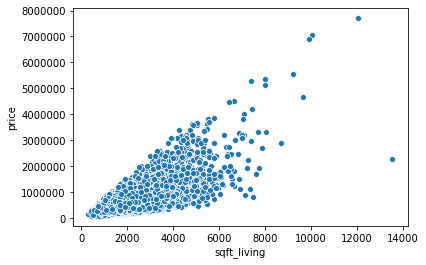

In [123]:
sns.scatterplot(x= 'sqft_living', y = 'price', data = df)

In [124]:
df['sqft_living'] = np.where((df.sqft_living > 12000)& (df.price < 30000000), 8000, df.sqft_living)

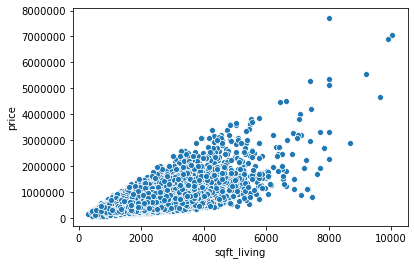

In [125]:
sns.scatterplot(x= 'sqft_living', y = 'price', data = df)

In [181]:
df['sqft_living'] = np.where((df.price > 6000000), 11000, df.sqft_living)
df['sqft_living'] = np.where((df.price < 1200000) & (df.sqft_living > 6500), 5500, df.sqft_living)

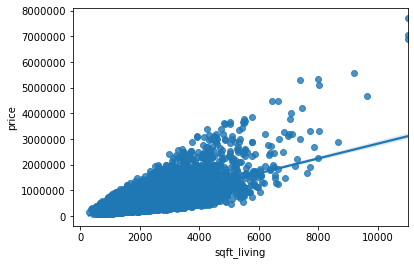

In [182]:
sns.regplot(x= 'sqft_living', y = 'price', data = df)

I can't imagine that outlier would help my model so I just made that datapoint's sqft lower manually, more in line with the overall trend. I assume it was a giant house in the middle of nowhere or something. Overall it looks like there is a strong correlation between square footage and price. The relationship could be exponential so I will expirement with that later.

In [183]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sqft_living""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     797.1
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:37:42   Log-Likelihood:            -2.3521e+05
No. Observations:               17290   AIC:                         4.705e+05
Df Residuals:                   17232   BIC:                         4.710e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.756e+05   4757.869    -36.907      0.000   -1.85e+05   -1.66e+05
zipcode_98004  8.088e+05   1.34e+04     60.548      0.000    7.83e+05    8.35e+05
zipcode_98005  2.964e+05    1.7e+04     17.436      0.000    2.63e+05     3.3e+05
zipcode_98006   2.91e+05   1.07e+04     27.108      0.000     2.7e+05    3.12e+05
zipcode_98007  2.371e+05   1.81e+04     13.106      0.000    2.02e+05    2.73e+05
zipcode_98008    2.7e+05   1.35e+04     19.992      0.000    2.43e+05    2.96e+05
zipcode_98010  4.424e+04   2.31e+04      1.918      0.055    -961.480    8.94e+04
zipcode_98011  9.112e+04   1.58e+04      5.782      0.000    6.02e+04    1.22e+05
zipcode_98014   9.09e+04   1.98e+04      4.586      0.000     5.2e+04     1.3e+05
zipcode_98019  3.771e+04   1.67e+04      2.263      0.024    5054.289    7.04e+04
zipcode_98024  1.599e+05   2.46e+04      6.502      0.000    1.12e+05    2.08e+05
zipcode_98027  1.461e+05   1.14e+04     12.855      0.000    1.24e+05    1.68e+05
zipcode_98028  9.601e+04   1.37e+04      7.006      0.000    6.91e+04    1.23e+05
zipcode_98029  1.994e+05   1.29e+04     15.454      0.000    1.74e+05    2.25e+05
zipcode_98033  3.635e+05    1.1e+04     33.009      0.000    3.42e+05    3.85e+05
zipcode_98034  1.925e+05      1e+04     19.216      0.000    1.73e+05    2.12e+05
zipcode_98038  -1.06e+04   9837.640     -1.078      0.281   -2.99e+04    8680.059
zipcode_98039  1.375e+06   3.07e+04     44.802      0.000    1.31e+06    1.43e+06
zipcode_98040   5.68e+05   1.36e+04     41.765      0.000    5.41e+05    5.95e+05
zipcode_98045  8.852e+04   1.52e+04      5.831      0.000    5.88e+04    1.18e+05
zipcode_98052  2.121e+05   9696.006     21.879      0.000    1.93e+05    2.31e+05
zipcode_98053  1.838e+05   1.15e+04     15.962      0.000    1.61e+05    2.06e+05
zipcode_98055  1.929e+04    1.4e+04      1.381      0.167   -8084.483    4.67e+04
zipcode_98056  7.729e+04   1.12e+04      6.873      0.000    5.52e+04    9.93e+04
zipcode_98058  7510.4963   1.06e+04      0.710      0.478   -1.32e+04    2.82e+04
zipcode_98059  5.159e+04   1.08e+04      4.788      0.000    3.05e+04    7.27e+04
zipcode_98065  4.898e+04    1.3e+04      3.778      0.000    2.36e+04    7.44e+04
zipcode_98070  1.812e+05      2e+04      9.057      0.000    1.42e+05     2.2e+05
zipcode_98072  1.378e+05   1.38e+04      9.953      0.000    1.11e+05    1.65e+05
zipcode_98074  1.879e+05    1.1e+04     17.043      0.000    1.66e+05    2.09e+05
zipcode_98075  2.017e+05   1.23e+04     16.429      0.000    1.78e+05    2.26e+05
zipcode_98077  1.195e+05   1.59e+04      7.518      0.000    8.84e+04    1.51e+05
zipcode_98092 -5.454e+04   1.21e+04     -4.501      0.000   -7.83e+04   -3.08e+04
zipcode_98102  5.354e+05   2.22e+04     24.110      0.000    4.92e+05    5.79e+05
zipcode_98103   3.39e+05   9766.508     34.707   

Hey thats not too shabby! Square footage jumped our R-squared by a whole .4, location and square footage alone unsurprisingly account for much of the variance in housing prices. If I was focusing on an interpretable model I would mainly hone in on these features. 

In [184]:
df['sq_sqft'] = df['sqft_living'] **2


In [185]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1022.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:37:47   Log-Likelihood:            -2.3359e+05
No. Observations:               17290   AIC:                         4.673e+05
Df Residuals:                   17232   BIC:                         4.678e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.16e+05   3313.042     35.026      0.000     1.1e+05    1.23e+05
zipcode_98004   7.85e+05   1.22e+04     64.485      0.000    7.61e+05    8.09e+05
zipcode_98005  3.204e+05   1.55e+04     20.715      0.000     2.9e+05    3.51e+05
zipcode_98006   2.93e+05   9760.502     30.024      0.000    2.74e+05    3.12e+05
zipcode_98007  2.594e+05   1.65e+04     15.743      0.000    2.27e+05    2.92e+05
zipcode_98008  2.856e+05   1.23e+04     23.224      0.000    2.61e+05     3.1e+05
zipcode_98010  5.021e+04    2.1e+04      2.390      0.017    9031.440    9.14e+04
zipcode_98011  1.181e+05   1.43e+04      8.232      0.000       9e+04    1.46e+05
zipcode_98014  7.787e+04   1.81e+04      4.312      0.000    4.25e+04    1.13e+05
zipcode_98019  6.109e+04   1.52e+04      4.027      0.000    3.14e+04    9.08e+04
zipcode_98024  1.467e+05   2.24e+04      6.551      0.000    1.03e+05    1.91e+05
zipcode_98027  1.566e+05   1.03e+04     15.146      0.000    1.36e+05    1.77e+05
zipcode_98028  1.186e+05   1.25e+04      9.503      0.000    9.41e+04    1.43e+05
zipcode_98029  2.261e+05   1.17e+04     19.258      0.000    2.03e+05    2.49e+05
zipcode_98033   3.73e+05      1e+04     37.216      0.000    3.53e+05    3.93e+05
zipcode_98034  2.014e+05   9125.288     22.069      0.000    1.83e+05    2.19e+05
zipcode_98038  1.324e+04   8953.022      1.478      0.139   -4312.622    3.08e+04
zipcode_98039  1.202e+06   2.81e+04     42.821      0.000    1.15e+06    1.26e+06
zipcode_98040  5.611e+05   1.24e+04     45.345      0.000    5.37e+05    5.85e+05
zipcode_98045  8.897e+04   1.38e+04      6.433      0.000    6.19e+04    1.16e+05
zipcode_98052  2.442e+05   8811.075     27.714      0.000    2.27e+05    2.61e+05
zipcode_98053  1.912e+05   1.05e+04     18.251      0.000    1.71e+05    2.12e+05
zipcode_98055  2.142e+04   1.27e+04      1.683      0.092   -3519.572    4.64e+04
zipcode_98056  8.597e+04   1.02e+04      8.393      0.000    6.59e+04    1.06e+05
zipcode_98058  2.155e+04   9634.561      2.237      0.025    2665.823    4.04e+04
zipcode_98059  7.156e+04   9800.278      7.302      0.000    5.23e+04    9.08e+04
zipcode_98065  7.336e+04   1.18e+04      6.223      0.000    5.02e+04    9.65e+04
zipcode_98070  1.845e+05   1.82e+04     10.120      0.000    1.49e+05     2.2e+05
zipcode_98072  1.586e+05   1.26e+04     12.590      0.000    1.34e+05    1.83e+05
zipcode_98074  2.137e+05      1e+04     21.343      0.000    1.94e+05    2.33e+05
zipcode_98075  2.333e+05   1.11e+04     20.951      0.000    2.12e+05    2.55e+05
zipcode_98077  1.272e+05   1.45e+04      8.791      0.000    9.88e+04    1.56e+05
zipcode_98092 -3.015e+04    1.1e+04     -2.734      0.006   -5.18e+04   -8532.452
zipcode_98102    4.9e+05   2.02e+04     24.213      0.000     4.5e+05     5.3e+05
zipcode_98103  3.277e+05   8895.521     36.837   

Thats a pretty significant increase in R squared. So Im going to stick with ssuare footage squared, say that five times fast.

# Interest Rate Analysis

I want to try and account for flucatating interest rates with some outside data. Ill just go month by month with a dataset I cleaned in another notebook. I need to make sure this merge goes smoothly enough to implement on the target data or its probably not worth the effort. 

In [186]:
df['year_month'] = df['date'].apply(lambda x: x[0:6])
df['year_month'] = df['year_month'].astype(str)

In [187]:
df = pd.merge(df,fedfunds, on = 'year_month', how = 'inner')
df = df.rename(columns = {'Effective Federal Funds Rate':'interest_rate'})

Nice, that wasn't too bad, lets chuck it in the model!

In [188]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1010.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:37:54   Log-Likelihood:            -2.3356e+05
No. Observations:               17290   AIC:                         4.672e+05
Df Residuals:                   17231   BIC:                         4.677e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.466e+04   1.18e+04      2.097      0.036    1611.388    4.77e+04
zipcode_98004     7.847e+05   1.22e+04     64.583      0.000    7.61e+05    8.09e+05
zipcode_98005     3.217e+05   1.54e+04     20.838      0.000    2.91e+05    3.52e+05
zipcode_98006      2.94e+05   9742.927     30.173      0.000    2.75e+05    3.13e+05
zipcode_98007     2.611e+05   1.64e+04     15.873      0.000    2.29e+05    2.93e+05
zipcode_98008     2.861e+05   1.23e+04     23.311      0.000    2.62e+05     3.1e+05
zipcode_98010     5.178e+04    2.1e+04      2.469      0.014    1.07e+04    9.29e+04
zipcode_98011     1.184e+05   1.43e+04      8.270      0.000    9.04e+04    1.47e+05
zipcode_98014     7.871e+04    1.8e+04      4.367      0.000    4.34e+04    1.14e+05
zipcode_98019     6.062e+04   1.51e+04      4.003      0.000    3.09e+04    9.03e+04
zipcode_98024     1.465e+05   2.24e+04      6.553      0.000    1.03e+05     1.9e+05
zipcode_98027     1.575e+05   1.03e+04     15.257      0.000    1.37e+05    1.78e+05
zipcode_98028     1.189e+05   1.25e+04      9.546      0.000    9.45e+04    1.43e+05
zipcode_98029     2.275e+05   1.17e+04     19.409      0.000    2.05e+05     2.5e+05
zipcode_98033     3.739e+05      1e+04     37.375      0.000    3.54e+05    3.94e+05
zipcode_98034     2.019e+05   9108.454     22.165      0.000    1.84e+05     2.2e+05
zipcode_98038     1.318e+04   8936.295      1.475      0.140   -4332.841    3.07e+04
zipcode_98039     1.205e+06    2.8e+04     43.017      0.000    1.15e+06    1.26e+06
zipcode_98040     5.615e+05   1.24e+04     45.463      0.000    5.37e+05    5.86e+05
zipcode_98045     9.055e+04   1.38e+04      6.558      0.000    6.35e+04    1.18e+05
zipcode_98052     2.457e+05   8796.479     27.927      0.000    2.28e+05    2.63e+05
zipcode_98053     1.927e+05   1.05e+04     18.427      0.000    1.72e+05    2.13e+05
zipcode_98055     2.147e+04   1.27e+04      1.691      0.091   -3415.581    4.64e+04
zipcode_98056     8.583e+04   1.02e+04      8.395      0.000    6.58e+04    1.06e+05
zipcode_98058     2.145e+04   9616.567      2.230      0.026    2595.802    4.03e+04
zipcode_98059     7.188e+04   9782.048      7.349      0.000    5.27e+04    9.11e+04
zipcode_98065     7.346e+04   1.18e+04      6.243      0.000    5.04e+04    9.65e+04
zipcode_98070     1.866e+05   1.82e+04     10.256      0.000    1.51e+05    2.22e+05
zipcode_98072     1.583e+05   1.26e+04     12.587      0.000    1.34e+05    1.83e+05
zipcode_98074     2.148e+05   9994.718     21.492      0.000    1.95e+05    2.34e+05
zipcode_98075     2.338e+05   1.11e+04     21.036      0.000    2.12e+05    2.56e+05
zipcode_98077     1.282e+05   1.44e+04      8.879      0.000    9.99e+04    1.57e+05
zipcode_98092     -3.09e+04    1.1e+04     -2.807      0.005   -5.25e+04   -9319.711
zipcode_98102     4.922

Well that was alot of work for an undewhelming improvement. It's still a significant variable though so I will leave it in. Also just realized that this data is only from 2014-2015 oops, interest rates probably dont fluctaute too much in that short of a time span. Atleast I learned a little about merging dataframes

# Old Houses Have Character

Lets take a look at the year built and year renovated and try and engineer them into something more useable. 

In [189]:
df['yrs_old'] = 2020 - df.yr_built

In [190]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate+yrs_old""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1078.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:37:57   Log-Likelihood:            -2.3360e+05
No. Observations:               17290   AIC:                         4.673e+05
Df Residuals:                   17235   BIC:                         4.677e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.087e+04    1.2e+04      1.739      0.082   -2646.852    4.44e+04
zipcode_98004     7.728e+05   1.21e+04     64.006      0.000    7.49e+05    7.96e+05
zipcode_98005       3.1e+05   1.54e+04     20.140      0.000     2.8e+05     3.4e+05
zipcode_98006     2.845e+05   9619.221     29.572      0.000    2.66e+05    3.03e+05
zipcode_98007     2.508e+05   1.64e+04     15.282      0.000    2.19e+05    2.83e+05
zipcode_98008     2.745e+05   1.22e+04     22.492      0.000    2.51e+05    2.98e+05
zipcode_98010     4.393e+04    2.1e+04      2.096      0.036    2857.521     8.5e+04
zipcode_98011     1.109e+05   1.43e+04      7.775      0.000    8.29e+04    1.39e+05
zipcode_98014      7.08e+04    1.8e+04      3.935      0.000    3.55e+04    1.06e+05
zipcode_98019     5.599e+04   1.51e+04      3.705      0.000    2.64e+04    8.56e+04
zipcode_98024     1.357e+05   2.23e+04      6.071      0.000    9.19e+04    1.79e+05
zipcode_98027     1.509e+05   1.02e+04     14.765      0.000    1.31e+05    1.71e+05
zipcode_98028     1.105e+05   1.24e+04      8.930      0.000    8.63e+04    1.35e+05
zipcode_98029     2.243e+05   1.17e+04     19.196      0.000    2.01e+05    2.47e+05
zipcode_98033     3.653e+05   9889.160     36.937      0.000    3.46e+05    3.85e+05
zipcode_98034     1.932e+05   8981.555     21.514      0.000    1.76e+05    2.11e+05
zipcode_98039     1.192e+06    2.8e+04     42.501      0.000    1.14e+06    1.25e+06
zipcode_98040     5.494e+05   1.23e+04     44.739      0.000    5.25e+05    5.73e+05
zipcode_98045     8.399e+04   1.37e+04      6.110      0.000     5.7e+04    1.11e+05
zipcode_98052     2.389e+05   8669.910     27.560      0.000    2.22e+05    2.56e+05
zipcode_98053     1.889e+05   1.04e+04     18.172      0.000    1.69e+05    2.09e+05
zipcode_98056     7.737e+04   1.01e+04      7.648      0.000    5.75e+04    9.72e+04
zipcode_98059     6.595e+04   9679.874      6.813      0.000     4.7e+04    8.49e+04
zipcode_98065     6.941e+04   1.17e+04      5.926      0.000    4.65e+04    9.24e+04
zipcode_98072     1.506e+05   1.25e+04     12.045      0.000    1.26e+05    1.75e+05
zipcode_98074     2.089e+05   9894.193     21.110      0.000    1.89e+05    2.28e+05
zipcode_98075     2.283e+05    1.1e+04     20.694      0.000    2.07e+05     2.5e+05
zipcode_98077     1.201e+05   1.44e+04      8.356      0.000    9.19e+04    1.48e+05
zipcode_98092    -3.605e+04   1.09e+04     -3.296      0.001   -5.75e+04   -1.46e+04
zipcode_98102      4.75e+05   2.02e+04     23.455      0.000    4.35e+05    5.15e+05
zipcode_98103     3.134e+05   8840.615     35.448      0.000    2.96e+05    3.31e+05
zipcode_98105     4.734e+05   1.41e+04     33.549      0.000    4.46e+05    5.01e+05
zipcode_98107      3.18e+05   1.26e+04     25.260      0.000    2.93e+05    3.43e+05
zipcode_98108     7.592

Years old seems to slightly reduce r squared even though it is significant. I think I'm going to keep it out of the model, since old houses can be considered desirable. 

Earlier I notice almost all the houses had not been renovated, lets just makes this a dummy variable

In [191]:
df['has_been_renovated'] = df['yr_renovated'].apply(lambda x: x>0).astype(int)

In [192]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate+has_been_renovated""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1086.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:37:59   Log-Likelihood:            -2.3355e+05
No. Observations:               17290   AIC:                         4.672e+05
Df Residuals:                   17235   BIC:                         4.676e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.004e+04   1.16e+04      2.580      0.010    7220.811    5.29e+04
zipcode_98004       7.713e+05    1.2e+04     64.117      0.000    7.48e+05    7.95e+05
zipcode_98005       3.136e+05   1.53e+04     20.449      0.000    2.84e+05    3.44e+05
zipcode_98006       2.853e+05   9589.592     29.749      0.000    2.66e+05    3.04e+05
zipcode_98007       2.535e+05   1.64e+04     15.500      0.000    2.21e+05    2.86e+05
zipcode_98008       2.778e+05   1.22e+04     22.853      0.000    2.54e+05    3.02e+05
zipcode_98010       3.928e+04   2.09e+04      1.880      0.060   -1673.475    8.02e+04
zipcode_98011       1.098e+05   1.42e+04      7.725      0.000     8.2e+04    1.38e+05
zipcode_98014       7.022e+04   1.79e+04      3.914      0.000    3.51e+04    1.05e+05
zipcode_98019       5.116e+04    1.5e+04      3.401      0.001    2.17e+04    8.06e+04
zipcode_98024       1.321e+05   2.23e+04      5.928      0.000    8.84e+04    1.76e+05
zipcode_98027       1.501e+05   1.02e+04     14.743      0.000     1.3e+05     1.7e+05
zipcode_98028       1.112e+05   1.23e+04      9.012      0.000     8.7e+04    1.35e+05
zipcode_98029       2.213e+05   1.16e+04     19.084      0.000    1.99e+05    2.44e+05
zipcode_98033       3.639e+05   9859.977     36.910      0.000    3.45e+05    3.83e+05
zipcode_98034       1.946e+05   8955.529     21.734      0.000    1.77e+05    2.12e+05
zipcode_98039        1.19e+06   2.79e+04     42.574      0.000    1.13e+06    1.24e+06
zipcode_98040       5.469e+05   1.22e+04     44.695      0.000    5.23e+05    5.71e+05
zipcode_98045       8.205e+04   1.37e+04      5.990      0.000    5.52e+04    1.09e+05
zipcode_98052       2.386e+05   8635.465     27.626      0.000    2.22e+05    2.55e+05
zipcode_98053       1.864e+05   1.03e+04     18.061      0.000    1.66e+05    2.07e+05
zipcode_98056       7.811e+04   1.01e+04      7.745      0.000    5.83e+04    9.79e+04
zipcode_98059       6.415e+04   9634.821      6.658      0.000    4.53e+04     8.3e+04
zipcode_98065       6.561e+04   1.16e+04      5.636      0.000    4.28e+04    8.84e+04
zipcode_98072         1.5e+05   1.25e+04     12.040      0.000    1.26e+05    1.74e+05
zipcode_98074       2.076e+05   9848.941     21.080      0.000    1.88e+05    2.27e+05
zipcode_98075       2.271e+05    1.1e+04     20.679      0.000    2.06e+05    2.49e+05
zipcode_98077       1.211e+05   1.43e+04      8.449      0.000     9.3e+04    1.49e+05
zipcode_98092      -3.823e+04   1.09e+04     -3.514      0.000   -5.96e+04   -1.69e+04
zipcode_98102       4.823e+05   2.01e+04     23.972      0.000    4.43e+05    5.22e+05
zipcode_98103        3.17e+05   8727.519     36.322      0.000       3e+05    3.34e+05
zipcode_98105       4.822e+05   1.39e+04     34.602      0.000    4.55e+05    5.09e+05
zipcode_98107       3.209e+05   1.25e+

Another significant one based on p values that does nothing to affect R squared

# Even Houses Get Graded

I'm going to turn the different grades into dummies since they are categorical, not sure how much it matters but it will also be interesting to see if a low grade has a big negative coefficient or if a high grade has a higher positive coefficient. 

In [193]:
df = pd.get_dummies(df, columns = ['grade'], drop_first = True)

KeyError: "None of [Index(['grade'], dtype='object')] are in the [columns]"

In [194]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,fall,winter,spring,summer,sqft_waterfront,bathroom_sqft,sqft_view,price_log,sq_sq,interest_rate
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,1,0,0,0,0,9641025.0,0,12.807653,4284900.0,0.09
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,1,0,0,0,0,8100000.0,0,13.429848,1822500.0,0.09
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,1,0,0,0,0,61781200.0,0,13.586257,11289600.0,0.09
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,1,0,0,0,0,2073600.0,0,12.779873,2073600.0,0.09
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,1,0,0,0,0,11676150.0,15568200,13.235692,2890000.0,0.09


In [195]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+ interest_rate
                            +grade_3
                            +grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+has_been_renovated""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1069.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:01   Log-Likelihood:            -2.3250e+05
No. Observations:               17290   AIC:                         4.651e+05
Df Residuals:                   17225   BIC:                         4.656e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.182e+06   5.45e+04     21.665      0.000    1.07e+06    1.29e+06
zipcode_98004       7.278e+05   1.14e+04     63.985      0.000    7.06e+05     7.5e+05
zipcode_98005       2.745e+05   1.45e+04     18.950      0.000    2.46e+05    3.03e+05
zipcode_98006       2.359e+05   9113.498     25.885      0.000    2.18e+05    2.54e+05
zipcode_98007       2.275e+05   1.54e+04     14.747      0.000    1.97e+05    2.58e+05
zipcode_98008       2.762e+05   1.15e+04     24.108      0.000    2.54e+05    2.99e+05
zipcode_98010       3.409e+04   1.97e+04      1.732      0.083   -4483.239    7.27e+04
zipcode_98011       1.036e+05   1.34e+04      7.734      0.000    7.74e+04     1.3e+05
zipcode_98014       6.889e+04   1.69e+04      4.073      0.000    3.57e+04    1.02e+05
zipcode_98019       5.698e+04   1.42e+04      4.021      0.000    2.92e+04    8.48e+04
zipcode_98024       1.193e+05    2.1e+04      5.683      0.000    7.82e+04     1.6e+05
zipcode_98027       1.281e+05   9621.911     13.313      0.000    1.09e+05    1.47e+05
zipcode_98028       1.113e+05   1.16e+04      9.567      0.000    8.85e+04    1.34e+05
zipcode_98029       1.769e+05    1.1e+04     16.011      0.000    1.55e+05    1.99e+05
zipcode_98033        3.37e+05   9318.659     36.163      0.000    3.19e+05    3.55e+05
zipcode_98034       1.853e+05   8456.296     21.918      0.000    1.69e+05    2.02e+05
zipcode_98039       1.124e+06   2.64e+04     42.578      0.000    1.07e+06    1.18e+06
zipcode_98040       4.969e+05   1.16e+04     42.804      0.000    4.74e+05     5.2e+05
zipcode_98045       7.045e+04   1.29e+04      5.460      0.000    4.52e+04    9.57e+04
zipcode_98052       2.113e+05   8210.578     25.732      0.000    1.95e+05    2.27e+05
zipcode_98053       1.672e+05   9749.558     17.145      0.000    1.48e+05    1.86e+05
zipcode_98056       7.731e+04   9523.831      8.117      0.000    5.86e+04     9.6e+04
zipcode_98059       5.176e+04   9096.475      5.690      0.000    3.39e+04    6.96e+04
zipcode_98065       6.829e+04    1.1e+04      6.222      0.000    4.68e+04    8.98e+04
zipcode_98072       1.286e+05   1.18e+04     10.936      0.000    1.06e+05    1.52e+05
zipcode_98074       1.531e+05   9419.749     16.258      0.000    1.35e+05    1.72e+05
zipcode_98075       1.675e+05   1.05e+04     15.920      0.000    1.47e+05    1.88e+05
zipcode_98077       7.099e+04   1.36e+04      5.235      0.000    4.44e+04    9.76e+04
zipcode_98092      -5.253e+04   1.03e+04     -5.112      0.000   -7.27e+04   -3.24e+04
zipcode_98102       4.387e+05    1.9e+04     23.081      0.000    4.01e+05    4.76e+05
zipcode_98103       3.048e+05   8232.840     37.020      0.000    2.89e+05    3.21e+05
zipcode_98105       4.654e+05   1.31e+04     35.439      0.000     4.4e+05    4.91e+05
zipcode_98107       3.038e+05   1.18e+

Pretty huge increase at this point in the game. No idea why grade has a negative coefficient, seams very counter intuitive, having a high grade has the lowest, must be something with dummy variables I dont understand. Lets chuck waterfront in there since thats already useable as is in the graph 

In [196]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+
                            grade_3+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+waterfront""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1328.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:02   Log-Likelihood:            -2.3109e+05
No. Observations:               17290   AIC:                         4.623e+05
Df Residuals:                   17226   BIC:                         4.628e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.342e+06   4.93e+04     27.214      0.000    1.25e+06    1.44e+06
zipcode_98004  7.528e+05   1.05e+04     71.846      0.000    7.32e+05    7.73e+05
zipcode_98005  2.893e+05   1.34e+04     21.668      0.000    2.63e+05    3.15e+05
zipcode_98006  2.509e+05   8400.241     29.863      0.000    2.34e+05    2.67e+05
zipcode_98007  2.331e+05   1.42e+04     16.399      0.000    2.05e+05    2.61e+05
zipcode_98008  2.591e+05   1.06e+04     24.545      0.000    2.38e+05     2.8e+05
zipcode_98010  4.732e+04   1.81e+04      2.610      0.009    1.18e+04    8.29e+04
zipcode_98011  1.121e+05   1.23e+04      9.080      0.000    8.79e+04    1.36e+05
zipcode_98014   7.86e+04   1.56e+04      5.043      0.000     4.8e+04    1.09e+05
zipcode_98019  6.694e+04   1.31e+04      5.127      0.000    4.13e+04    9.25e+04
zipcode_98024  1.372e+05   1.93e+04      7.095      0.000    9.93e+04    1.75e+05
zipcode_98027  1.375e+05   8866.556     15.512      0.000     1.2e+05    1.55e+05
zipcode_98028  1.142e+05   1.07e+04     10.658      0.000    9.32e+04    1.35e+05
zipcode_98029   1.84e+05   1.02e+04     18.074      0.000    1.64e+05    2.04e+05
zipcode_98033  3.412e+05   8584.755     39.743      0.000    3.24e+05    3.58e+05
zipcode_98034  1.819e+05   7790.521     23.345      0.000    1.67e+05    1.97e+05
zipcode_98039  1.148e+06   2.43e+04     47.208      0.000     1.1e+06     1.2e+06
zipcode_98040  4.923e+05   1.07e+04     46.067      0.000    4.71e+05    5.13e+05
zipcode_98045  7.766e+04   1.19e+04      6.532      0.000    5.44e+04    1.01e+05
zipcode_98052  2.158e+05   7563.796     28.532      0.000    2.01e+05    2.31e+05
zipcode_98053  1.777e+05   8983.358     19.782      0.000     1.6e+05    1.95e+05
zipcode_98056  7.807e+04   8774.447      8.898      0.000    6.09e+04    9.53e+04
zipcode_98059  6.259e+04   8383.304      7.465      0.000    4.62e+04     7.9e+04
zipcode_98065  7.966e+04   1.01e+04      7.876      0.000    5.98e+04    9.95e+04
zipcode_98072  1.401e+05   1.08e+04     12.929      0.000    1.19e+05    1.61e+05
zipcode_98074  1.552e+05   8678.297     17.878      0.000    1.38e+05    1.72e+05
zipcode_98075   1.57e+05   9695.545     16.191      0.000    1.38e+05    1.76e+05
zipcode_98077   8.78e+04   1.25e+04      7.026      0.000    6.33e+04    1.12e+05
zipcode_98092  -4.39e+04   9467.374     -4.637      0.000   -6.25e+04   -2.53e+04
zipcode_98102  4.484e+05   1.75e+04     25.608      0.000    4.14e+05    4.83e+05
zipcode_98103  3.128e+05   7582.155     41.251      0.000    2.98e+05    3.28e+05
zipcode_98105  4.664e+05   1.21e+04     38.555      0.000    4.43e+05     4.9e+05
zipcode_98107  3.105e+05   1.09e+04     28.519      0.000    2.89e+05    3.32e+05
zipcode_98108  8.708e+04   1.28e+04      6.807      0.000     6.2e+04    1.12e+05
zipcode_98109  4.895e+05   1.69e+04     28.881   

Wooooo! We broke the .8 R-squared barrier, this is the greatest model ever made. Did not expect water front to matter so much since there are only 100ish data points that have it, but apparently its a big deal, especially when we are hunting down minute improvements. 

# Time of Year Analysis

Lets take a look at time of year, no one likes moving in the winter. Im just going to make season columns first. 

In [197]:
df['month'] = df['date'].apply(lambda x: x[4:6])

In [198]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,fall,winter,spring,summer,sqft_waterfront,bathroom_sqft,sqft_view,price_log,sq_sq,interest_rate
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,1,0,0,0,0,9641025.0,0,12.807653,4284900.0,0.09
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,1,0,0,0,0,8100000.0,0,13.429848,1822500.0,0.09
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,1,0,0,0,0,61781200.0,0,13.586257,11289600.0,0.09
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,1,0,0,0,0,2073600.0,0,12.779873,2073600.0,0.09
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,1,0,0,0,0,11676150.0,15568200,13.235692,2890000.0,0.09


In [199]:
df['month'] = df['month'].astype(int)
df['fall'] = df['month'].apply(lambda x: x>9).astype(int)
df['winter'] = df['month'].apply(lambda x: x<3).astype(int)
df['spring'] = df['month'].apply(lambda x: 6>x>3).astype(int)
df['summer'] = df['month'].apply(lambda x: 9>x>6).astype(int)
df.head(20)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,fall,winter,spring,summer,sqft_waterfront,bathroom_sqft,sqft_view,price_log,sq_sq,interest_rate
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,1,0,0,0,0,9641025.0,0,12.807653,4284900.0,0.09
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,1,0,0,0,0,8100000.0,0,13.429848,1822500.0,0.09
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,1,0,0,0,0,61781200.0,0,13.586257,11289600.0,0.09
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,1,0,0,0,0,2073600.0,0,12.779873,2073600.0,0.09
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,1,0,0,0,0,11676150.0,15568200,13.235692,2890000.0,0.09
5,33,16000200,20141024T000000,250000.0,3,2.25,1640,4420,2.0,0,...,1,0,0,0,0,6051600.0,0,12.429216,2689600.0,0.09
6,53,2770601800,20141024T000000,525000.0,3,1.75,1560,6000,1.0,0,...,1,0,0,0,0,4258800.0,0,13.171154,608400.0,0.09
7,59,3224600340,20141013T000000,695000.0,4,2.50,2790,6540,2.0,0,...,1,0,0,0,0,19460250.0,0,13.451667,7784100.0,0.09
8,62,7893207925,20141022T000000,265000.0,3,1.50,1290,7100,1.0,0,...,1,0,0,0,0,2496150.0,0,12.487485,1664100.0,0.09
9,64,8024200010,20141028T000000,312000.0,2,1.00,1460,6000,1.0,0,...,1,0,0,0,0,2131600.0,0,12.650758,1587600.0,0.09


In [200]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate
                            +grade_3
                            +grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+waterfront+spring+summer+fall+winter""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1241.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:05   Log-Likelihood:            -2.3102e+05
No. Observations:               17290   AIC:                         4.622e+05
Df Residuals:                   17221   BIC:                         4.627e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.248e+06   5.05e+04     24.704      0.000    1.15e+06    1.35e+06
zipcode_98004     7.524e+05   1.04e+04     72.060      0.000    7.32e+05    7.73e+05
zipcode_98005     2.909e+05   1.33e+04     21.866      0.000    2.65e+05    3.17e+05
zipcode_98006     2.515e+05   8371.163     30.047      0.000    2.35e+05    2.68e+05
zipcode_98007     2.331e+05   1.42e+04     16.454      0.000    2.05e+05    2.61e+05
zipcode_98008     2.597e+05   1.05e+04     24.684      0.000    2.39e+05     2.8e+05
zipcode_98010     4.861e+04   1.81e+04      2.690      0.007    1.32e+04     8.4e+04
zipcode_98011      1.13e+05   1.23e+04      9.181      0.000    8.89e+04    1.37e+05
zipcode_98014     7.868e+04   1.55e+04      5.065      0.000    4.82e+04    1.09e+05
zipcode_98019     6.561e+04    1.3e+04      5.043      0.000    4.01e+04    9.11e+04
zipcode_98024     1.363e+05   1.93e+04      7.074      0.000    9.86e+04    1.74e+05
zipcode_98027     1.373e+05   8837.574     15.537      0.000     1.2e+05    1.55e+05
zipcode_98028     1.134e+05   1.07e+04     10.619      0.000    9.25e+04    1.34e+05
zipcode_98029     1.843e+05   1.01e+04     18.172      0.000    1.64e+05    2.04e+05
zipcode_98033     3.415e+05   8556.649     39.908      0.000    3.25e+05    3.58e+05
zipcode_98034     1.824e+05   7763.541     23.500      0.000    1.67e+05    1.98e+05
zipcode_98039     1.151e+06   2.42e+04     47.506      0.000     1.1e+06     1.2e+06
zipcode_98040     4.909e+05   1.07e+04     46.089      0.000     4.7e+05    5.12e+05
zipcode_98045     7.842e+04   1.18e+04      6.618      0.000    5.52e+04    1.02e+05
zipcode_98052     2.162e+05   7539.842     28.680      0.000    2.01e+05    2.31e+05
zipcode_98053     1.787e+05   8953.399     19.960      0.000    1.61e+05    1.96e+05
zipcode_98056     7.773e+04   8743.965      8.889      0.000    6.06e+04    9.49e+04
zipcode_98059     6.266e+04   8354.664      7.500      0.000    4.63e+04     7.9e+04
zipcode_98065     7.869e+04   1.01e+04      7.805      0.000    5.89e+04    9.85e+04
zipcode_98072     1.405e+05   1.08e+04     13.011      0.000    1.19e+05    1.62e+05
zipcode_98074     1.555e+05   8649.605     17.975      0.000    1.39e+05    1.72e+05
zipcode_98075     1.566e+05   9662.289     16.208      0.000    1.38e+05    1.76e+05
zipcode_98077     8.824e+04   1.25e+04      7.085      0.000    6.38e+04    1.13e+05
zipcode_98092    -4.512e+04   9434.543     -4.782      0.000   -6.36e+04   -2.66e+04
zipcode_98102      4.52e+05   1.75e+04     25.900      0.000    4.18e+05    4.86e+05
zipcode_98103     3.126e+05   7558.399     41.352      0.000    2.98e+05    3.27e+05
zipcode_98105     4.677e+05   1.21e+04     38.798      0.000    4.44e+05    4.91e+05
zipcode_98107     3.108e+05   1.09e+04     28.648      0.000     2.9e+05    3.32e+05
zipcode_98108      8.94

Not much of an effect, also, only winter and fall are significant.

# Transformations Interactions Oh Me Oh My!

I have a hunch that sq foot pricing interacts with waterfront for some of the extremely expensive houses. I also took a look at some other interactions you can see below. Many of these made the model worse however and did not end up being included, so I wont talk about each one, just include what was significant in the model. 

In [201]:
df['sqft_waterfront'] = df['sq_sqft'] * df['waterfront']
df['bathroom_sqft'] = df['sq_sqft'] * df['bathrooms']
df['sqft_view'] = df['sq_sqft'] * df['view']
df['price_log'] = np.log(df['price']) 

In [278]:
slr_model = ols(formula= """price_log~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+sqft_living
                            +grade_3+view_1+view_2+view_3+view_4
                            +grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+waterfront+sqft_living15+winter+fall+sqft_basement+ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9""", data=df).fit()
slr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1510.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:34:44   Log-Likelihood:                 4055.5
No. Observations:               17290   AIC:                            -7959.
Df Residuals:                   17214   BIC:                            -7369.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.7170      0.063    200.484      0.000      12.593      12.841
zipcode_98004     0.8468      0.016     54.490      0.000       0.816       0.877
zipcode_98005     0.4725      0.019     25.347      0.000       0.436       0.509
zipcode_98006     0.4036      0.012     32.336      0.000       0.379       0.428
zipcode_98007     0.3791      0.020     19.309      0.000       0.341       0.418
zipcode_98008     0.3766      0.016     23.699      0.000       0.345       0.408
zipcode_98010     0.1926      0.023      8.345      0.000       0.147       0.238
zipcode_98011     0.0535      0.021      2.499      0.012       0.012       0.095
zipcode_98014    -0.0110      0.027     -0.402      0.688      -0.064       0.043
zipcode_98019    -0.0756      0.024     -3.177      0.001      -0.122      -0.029
zipcode_98024     0.2197      0.027      8.261      0.000       0.168       0.272
zipcode_98027     0.2890      0.013     22.119      0.000       0.263       0.315
zipcode_98028     0.0321      0.020      1.611      0.107      -0.007       0.071
zipcode_98029     0.3173      0.015     20.542      0.000       0.287       0.348
zipcode_98033     0.4425      0.015     28.627      0.000       0.412       0.473
zipcode_98034     0.1776      0.016     10.951      0.000       0.146       0.209
zipcode_98039     1.0187      0.031     32.361      0.000       0.957       1.080
zipcode_98040     0.6456      0.015     43.774      0.000       0.617       0.674
zipcode_98045     0.1402      0.021      6.563      0.000       0.098       0.182
zipcode_98052     0.2875      0.015     19.037      0.000       0.258       0.317
zipcode_98053     0.2356      0.017     13.562      0.000       0.202       0.270
zipcode_98056     0.1234      0.012     10.422      0.000       0.100       0.147
zipcode_98059     0.1372      0.011     11.978      0.000       0.115       0.160
zipcode_98065     0.1188      0.018      6.761      0.000       0.084       0.153
zipcode_98072     0.1134      0.020      5.598      0.000       0.074       0.153
zipcode_98074     0.2355      0.015     15.621      0.000       0.206       0.265
zipcode_98075     0.2595      0.015     16.753      0.000       0.229       0.290
zipcode_98077     0.0773      0.022      3.484      0.000       0.034       0.121
zipcode_98092     0.0001      0.012      0.010      0.992      -0.024       0.024
zipcode_98102     0.6704      0.024     28.318      0.000       0.624       0.717
zipcode_98103     0.5122      0.015     34.572      0.000       0.483       0.541
zipcode_98105     0.6408      0.018     34.969      0.000       0.605       0.677
zipcode_98107     0.5348      0.018     29.963      0.000       0.500       0.570
zipcode_98108     0.1338      0.017      7.927      0.000       0.101       0.167
zipcode_98109     0.6918      0.023     29.851   

In [244]:
df = pd.get_dummies(df, columns = ['view'], drop_first = True)
df = pd.get_dummies(df, columns = ['bathrooms'], drop_first = True)


In [245]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0
0,0,2591820310,20141006T000000,365000.0,4,2070,8893,2.0,0,4,...,0,0,0,0,0,0,0,0,0,0
1,7,7010701383,20141017T000000,680000.0,3,1800,4400,1.0,0,5,...,0,0,0,0,0,0,0,0,0,0
2,17,2386000070,20141029T000000,795127.0,4,4360,91158,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,18,1138000450,20141016T000000,355000.0,4,1440,7215,1.5,0,3,...,0,0,0,0,0,0,0,0,0,0
4,23,9324800450,20141009T000000,560000.0,3,2790,6900,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0


# RMSE SCORE

This cell is just to get my factors into a useable list for the sklearn model. 

In [279]:
factors = """zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft
                            +grade_3+sqft_living+view_1+view_2+view_3+view_4
                            +grade_4+grade_5+grade_6+grade_7+grade_8+bedrooms+floors+grade_9+grade_10+grade_11+grade_12+waterfront+winter+fall
                           +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9 """
factors = factors.replace(' ', '')
factors = factors.replace('\n', '')
factors = factors.split('+')
factors.remove('' )
df[factors]

,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98024,...,ll1,ll0,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9
0,0,0,0,0,0,0,0,0,0,0,...,0.047309,0.062402,0.042833,0.041179,0.037367,0.017754,0.058997,0.016275,0.110334,0.036373
1,0,0,0,0,0,0,0,0,0,0,...,0.033222,0.006235,0.025200,0.027530,0.032323,0.043966,0.034507,0.045184,0.021448,0.032858
2,0,0,0,0,0,0,0,0,0,0,...,0.052545,0.114344,0.065111,0.061623,0.055501,0.056508,0.052438,0.057481,0.099015,0.055117
3,0,0,0,0,0,0,0,0,0,0,...,0.004011,0.019293,0.007640,0.007564,0.008182,0.022564,0.001341,0.024434,0.005920,0.008605
4,0,0,0,0,0,0,0,0,0,0,...,0.012332,0.011834,0.012769,0.013820,0.016636,0.034882,0.009076,0.036990,0.000336,0.017305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,0,0,0,0,0,0,0,0,...,0.083619,0.113813,0.081361,0.078465,0.072088,0.045254,0.097354,0.043200,0.166294,0.070712
17286,0,0,0,0,0,0,0,0,0,0,...,0.017003,0.033692,0.015494,0.014248,0.011675,0.002831,0.024040,0.002427,0.061343,0.011121
17287,0,0,0,0,0,0,0,0,0,0,...,0.150981,0.146049,0.136522,0.135127,0.130828,0.091084,0.172491,0.087441,0.241430,0.129100
17288,0,0,0,0,0,0,0,0,0,0,...,0.002152,0.023799,0.006221,0.005524,0.004788,0.014038,0.001225,0.015460,0.016101,0.004963


In [280]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df[factors], test_size=0.2, random_state=42)

In [281]:
target = df['price_log']

target

0        12.807653
1        13.429848
2        13.586257
3        12.779873
4        13.235692
           ...    
17285    13.287878
17286    13.190022
17287    12.429216
17288    13.122363
17289    12.965710
Name: price_log, Length: 17290, dtype: float64

In [282]:
#improt train_test_split from sklearn package
from sklearn.model_selection import train_test_split

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df[factors], target, random_state=34,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)


Training set - Features:  (13832, 82) Target:  (13832,)
Training set - Features:  (3458, 82) Target:  (3458,)


In [283]:
from sklearn import linear_model

#instantiate a linear regression object
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)


print(lm.intercept_)
print(lm.coef_)


12.890306415171452
[ 8.76990624e-01  4.70059275e-01  4.16910707e-01  3.94831502e-01
  3.70755711e-01  1.87328557e-01  9.66211716e-02  2.10557052e-02
 -5.14299892e-02  2.31778505e-01  2.88372046e-01  6.08815271e-02
  3.30714059e-01  4.58287909e-01  1.93654670e-01  1.04047842e+00
  6.62289211e-01  1.38673600e-01  3.17061779e-01  2.71283245e-01
  1.21196100e-01  1.70733321e-01  1.55026107e-01  1.44482316e-01
  2.67330797e-01  3.05564775e-01  1.31779160e-01  1.00139051e-02
  6.89825948e-01  5.26821261e-01  6.61110798e-01  5.55695911e-01
  1.40134148e-01  7.09828522e-01  7.76185965e-01  4.92701463e-01
  5.30334678e-01  5.10317333e-01  2.37027457e-01  7.12785057e-01
  5.40071983e-01  2.25140987e-01  3.35161393e-01  1.42623190e-01
  4.89214113e-01  4.24408355e-01  1.04892386e-01  8.49600259e-02
  1.70446930e-01  2.96560334e-01  5.89404525e-01 -2.22141819e-08
 -9.49900453e-01  3.67364956e-04  1.18585472e-01  1.23407487e-01
  2.00780387e-01  2.90973383e-01 -9.63900668e-01 -8.85454024e-01
 -8.01

In [284]:
y_train_pred = np.exp(lm.predict(X_train))
y_test_pred = np.exp(lm.predict(X_test))
print ("R^2 Score:", lm.score(X_train, y_train))


R^2 Score: 0.8631873370810124


In [285]:
from sklearn import metrics

train_mae = metrics.mean_absolute_error(np.exp(y_train), y_train_pred)
train_mse = metrics.mean_squared_error(np.exp(y_train), y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train), y_train_pred))


print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 78285.64571044651
Mean Squared Error: 19754668723.119354
Root Mean Squared Error: 140551.30281544654


In [286]:
test_mae = metrics.mean_absolute_error(np.exp(y_test), y_test_pred)
test_mse = metrics.mean_squared_error(np.exp(y_test), y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), y_test_pred))


print('Mean Absolute Error:', test_mae )
print('Mean Squared Error:',  test_mse)
print('Root Mean Squared Error:' , test_rmse)

Mean Absolute Error: 77966.18518243793
Mean Squared Error: 16722631447.544443
Root Mean Squared Error: 129316.01388669712


In [256]:
residuals = (np.exp(y_test)- y_test_pred)

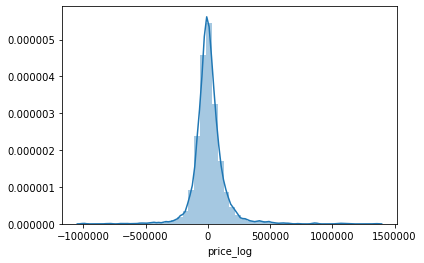

In [257]:
sns.distplot(residuals)

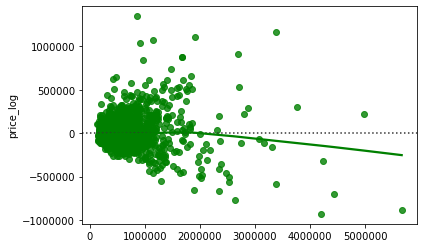

In [258]:
sns.residplot(y_test_pred, np.exp(y_test), lowess=True, color="g")

In [229]:
df.to_csv('data_with_all_features.csv')

My residuals look very normally distributed, they have a slight upward trend but its pretty minor. They are centered around zero which seems like a good thing. 

In [179]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df[factors], df['price'])
lm_final

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [180]:
import pickle


pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()